In [1]:
import _pipeline
import random


In [2]:
import json

# Bidi override characters
LRO = chr(0x202D)  # Left-to-Right Override
RLO = chr(0x202E)  # Right-to-Left Override
LRI = chr(0x2066)  # Left-to-Right Isolate
RLI = chr(0x2067)  # Right-to-Left Isolate
PDI = chr(0x2069)  # Pop Directional Isolate
PDF = chr(0x202C)  # Pop Directional Formatting



class TagAttack:
    def __init__(self, perturbation_budget, tags= [0xE0001,*range(0xE0020, 0xE007F+1)]):
        self.perturbation_budget = perturbation_budget
        self.tags = tags

    def perturb(self, text):
        """
        Insert random Unicode tag characters into text, treating each
        Unicode codepoint as a single character.
        """
        # Convert string to list of codepoints
        codepoints = [ord(c) for c in text]

        for i in range(self.perturbation_budget):
            # Choose random position in codepoint list
            rand_index = random.randrange(len(codepoints) + 1)  # +1 to allow appending
            rand_tag = random.choice(self.tags)

            # Insert the tag codepoint at the chosen position
            codepoints.insert(rand_index, rand_tag)

        # Convert back to string
        return "".join(chr(cp) for cp in codepoints)


class VariationSelectorAttack:
    def __init__(self, perturbation_budget, variation_selectors = [*range(0xFE00, 0xFE0F + 1), *range(0xE0100, 0xE01EF + 1)]):
        self.perturbation_budget = perturbation_budget
        self.variation_selectors = variation_selectors

    def perturb(self, text):
        # Convert string to list of codepoints
        codepoints = [ord(c) for c in text]

        for _ in range(self.perturbation_budget):
            # Choose random position in codepoint list
            rand_index = random.randrange(len(codepoints) + 1)  # allow append
            rand_vs = random.choice(self.variation_selectors)

            # Insert the variation selector codepoint
            codepoints.insert(rand_index, rand_vs)

        # Convert back to string
        return "".join(chr(cp) for cp in codepoints)


class InvisibleCharAttack:
    def __init__(self, perturbation_budget, invisible_chars=[0x200B, 0x200C, 0x200D, 0x2060, 0xFEFF]):
        self.perturbation_budget = perturbation_budget
        self.invisible_chars = invisible_chars

    def perturb(self, text):
        # Convert string to list of codepoints
        codepoints = [ord(c) for c in text]

        for _ in range(self.perturbation_budget):
            # Choose random position in codepoint list
            rand_index = random.randrange(len(codepoints) + 1)  # allow append
            rand_invisible = random.choice(self.invisible_chars)

            # Insert the invisible character
            codepoints.insert(rand_index, rand_invisible)

        # Convert back to string
        return "".join(chr(cp) for cp in codepoints)


class HomoglyphAttack:
    def __init__(self, perturbation_budget, homoglyph_map_path='/home/carolkhor/YearII/Dissertation/imperceptible-perturbations/project/utils/homoglyphs/intentional.json'):
        self.perturbation_budget = perturbation_budget
        with open(homoglyph_map_path, 'r') as f:
            hex_map = json.load(f)
        # Convert hex strings to codepoints
        self.homoglyph_map = {int(k, 16): int(v, 16) for k, v in hex_map.items()}
        self.homoglyph_chars = list(self.homoglyph_map.keys())

    def perturb(self, text):
        # Convert string to list of codepoints
        codepoints = [ord(c) for c in text]
        
        # Replace random characters with homoglyphs
        indices = list(range(len(codepoints)))
        random.shuffle(indices)
        
        for i in indices[:min(self.perturbation_budget, len(indices))]:
            cp = codepoints[i]
            # If character has a homoglyph, replace it
            if cp in self.homoglyph_map:
                codepoints[i] = self.homoglyph_map[cp]

        # Convert back to string
        return "".join(chr(cp) for cp in codepoints)


class DeletionCharAttack:
    def __init__(self, perturbation_budget, deletion_char=0x8):
        self.perturbation_budget = perturbation_budget
        self.deletion_char = deletion_char  # Backspace character
        self.ascii_chars = list(range(32, 127))  # Printable ASCII characters

    def perturb(self, text):
        # Convert string to list of codepoints
        codepoints = [ord(c) for c in text]
        
        for _ in range(self.perturbation_budget):
            # Choose random position in codepoint list
            rand_index = random.randrange(len(codepoints) + 1)  # allow append
            # Insert random ASCII character followed by deletion character
            rand_ascii = random.choice(self.ascii_chars)
            codepoints.insert(rand_index, rand_ascii)
            codepoints.insert(rand_index + 1, self.deletion_char)

        # Convert back to string
        return "".join(chr(cp) for cp in codepoints)

import json
import random

# Bidi override characters
RLO = chr(0x202E)   # Right-to-Left Override
PDF = chr(0x202C)   # Pop Directional Formatting
RLI = chr(0x2067)   # Right-to-Left Isolate
PDI = chr(0x2069)   # Pop Directional Isolate
LRO = chr(0x202D)   # Left-to-Right Override
LRI = chr(0x2066)   # Left-to-Right Isolate
# ... (Other classes like Swap, TagAttack, etc., remain unchanged) ...

class BidiAttack:
    def __init__(self, perturbation_budget):
        self.perturbation_budget = perturbation_budget
    
    def _encode_swap_spoof(self, one, two):
        """
        Creates a string that contains the characters 'two' followed by 'one' 
        in the data, but is displayed as 'one' followed by 'two'.
        Sequence: RLO + two + one + PDF
        """
        # LRO, LRI, RLO, LRI, el.two, PDI, LRI, el.one, PDI, PDF, PDI, PDF
        
        # Display order is visually reversed by RLO
        return LRO + LRI+ RLO + LRI + two + PDI + LRI + one + PDI + PDF + PDI + PDF

    def perturb(self, text):
        """
        Swaps random *non-overlapping* adjacent character pairs in the 
        underlying data and uses Bidi controls to visually reverse the swap.
        """
        chars = list(text)
        n = len(chars)
        
        possible_start_indices = list(range(n - 1))
        random.shuffle(possible_start_indices)
        
        swaps_to_make = set()
        swaps_remaining = self.perturbation_budget
        
        # Select non-overlapping swap positions
        for i in possible_start_indices:
            if i not in swaps_to_make and i + 1 not in swaps_to_make:
                if swaps_remaining > 0:
                    swaps_to_make.add(i)
                    # Add the next index to the set to prevent it from starting a new swap
                    swaps_to_make.add(i + 1) 
                    swaps_remaining -= 1
                else:
                    break

        swaps_to_make = []
        available_positions = list(range(n - 1))
        random.shuffle(available_positions)
        
        processed_indices = set()
        
        for pos in available_positions:
            # A swap starts at 'pos' and involves 'pos' and 'pos + 1'
            if pos not in processed_indices and (pos + 1) not in processed_indices:
                if len(swaps_to_make) < self.perturbation_budget:
                    swaps_to_make.append(pos)
                    # Mark both characters in the pair as 'used'
                    processed_indices.add(pos)
                    processed_indices.add(pos + 1)
                else:
                    break
        
        
        # Build perturbed text
        perturbed_text = ""
        i = 0
        while i < n:
            if i in swaps_to_make and chars[i].isalpha() and chars[i + 1].isalpha():
                # This index starts a swap
                char_one = chars[i]
                char_two = chars[i + 1]
                
                # Data: two, one (visually displays as: one, two)
                spoofed_pair = self._encode_swap_spoof(char_one, char_two)
                perturbed_text += spoofed_pair
                
                # Advance counter by 2 since both characters were processed
                i += 2 
            else:
                # Add normal character
                perturbed_text += chars[i]
                i += 1
                
        return perturbed_text

In [161]:
txt = " ."
txt = "ab"
bidi_attack = BidiAttack(perturbation_budget=3)
deletion_attack = DeletionCharAttack(perturbation_budget=3)
perturbed = deletion_attack.perturb(txt)

perturbed = bidi_attack.perturb(perturbed)

print(f"Perturbed: '{perturbed}'")
print(f"Length in codepoints: {len(perturbed)}")
print(f"Codepoints: {[hex(ord(c)) for c in perturbed]}")

p = _pipeline.Pipeline()
p.add_bidi_sanitizer()
# p.add_invisible_sanitizer()

p.add_combined_sanitizer()
p.add_deletion_sanitizer()

sanitised = p.sanitize(perturbed)
print(txt == sanitised)
print(sanitised)


print(f"Sanitised: {[hex(ord(c)) for c in sanitised]}")
print(f"Text: {[hex(ord(c)) for c in txt]}")

Perturbed: '‭⁦‮⁦g⁩⁦a⁩‬⁩b'
Length in codepoints: 18
Codepoints: ['0x202d', '0x2066', '0x202e', '0x2066', '0x67', '0x2069', '0x2066', '0x61', '0x2069', '0x202c', '0x2069', '0x202c', '0x8', '0x75', '0x8', '0x6d', '0x8', '0x62']
True
ab
Sanitised: ['0x61', '0x62']
Text: ['0x61', '0x62']


In [4]:
delAttack = DeletionCharAttack(perturbation_budget=3)
txt = "abc"
del_text = delAttack.perturb(txt)
print(f"Perturbed: '{del_text}'")
print(f"Length in codepoints: {len(del_text)}")
print(f"Codepoints: {[hex(ord(c)) for c in del_text]}")

p = _pipeline.Pipeline()
p.add_deletion_sanitizer()
sanitised = p.sanitize(del_text)
print(f"Sanitised: {[hex(ord(c)) for c in sanitised]}")

Perturbed: 'abc'
Length in codepoints: 9
Codepoints: ['0x57', '0x7d', '0x8', '0x8', '0x7a', '0x8', '0x61', '0x62', '0x63']
Sanitised: ['0x61', '0x62', '0x63']


In [5]:
tagAttack = TagAttack(perturbation_budget=3)
txt = "abc"
tag_text = tagAttack.perturb(txt)
print(f"Perturbed: '{tag_text}'")
print(f"Length in codepoints: {len(tag_text)}")
print(f"Codepoints: {[hex(ord(c)) for c in tag_text]}")

p = _pipeline.Pipeline()
p.add_combined_sanitizer()
sanitised = p.sanitize(tag_text)
print(f"Sanitised: {[hex(ord(c)) for c in sanitised]}")

Perturbed: 'ab󠁝󠀽󠀲c'
Length in codepoints: 6
Codepoints: ['0x61', '0x62', '0xe005d', '0xe003d', '0xe0032', '0x63']
Sanitised: ['0x61', '0x62', '0x63']


In [6]:
variationSelectorAttack = VariationSelectorAttack(perturbation_budget=3)
perturbed = variationSelectorAttack.perturb("abc")
print(f"Perturbed: '{perturbed}'")
print(f"Length in codepoints: {len(perturbed)}")
print(f"Codepoints: {[hex(ord(c)) for c in perturbed]}")

p = _pipeline.Pipeline()
p.add_combined_sanitizer()
sanitised = p.sanitize(perturbed)
print(f"Sanitised: {[hex(ord(c)) for c in sanitised]}")

Perturbed: 'ab󠆳︆c󠅸'
Length in codepoints: 6
Codepoints: ['0x61', '0x62', '0xe01b3', '0xfe06', '0x63', '0xe0178']
Sanitised: ['0x61', '0x62', '0x63']


# Example Sentiment Analysis Task

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# 1. Load the pre-trained model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# 2. Prepare the input text
text = "RoBERTa is an incredibly powerful model for NLP tasks!"

# 3. Tokenize and predict
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

# 4. Interpret the result
scores = output.logits[0].detach().numpy()
# Get the predicted class index (e.g., 0, 1, or 2)
predicted_class_id = scores.argmax()

# The model's config contains the mapping from ID to label
labels = model.config.id2label
predicted_label = labels[predicted_class_id]

print(f"Text: {text}")
print(f"Predicted Sentiment: {predicted_label}")
# Output for this example would likely be: Predicted Sentiment: LABEL_2 (Positive)

/home/carolkhor/YearII/Dissertation/imperceptible-perturbations/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text: RoBERTa is an incredibly powerful model for NLP tasks!
Predicted Sentiment: LABEL_2


# Sanitizer Performance Timing

In [200]:
! pip install lorem-text

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [201]:
from lorem_text import lorem
def lorem_words(n):
    words = []
    while len(words) < n:
        words.extend(lorem.sentence().split())
    return " ".join(words[:n])

print(lorem_words(50))

Commodi explicabo delectus esse dolor fuga est sunt eius eaque, accusantium eos quo nam aliquid quia beatae autem quod, exercitationem perferendis quasi neque deleniti, velit dolore non nisi tempora odio? Ipsa sed quibusdam excepturi, autem repudiandae libero praesentium, laborum non laudantium esse alias quibusdam voluptatibus autem. Vel nam quibusdam nostrum


In [219]:
import csv
import time
import pandas as pd

# Configuration
input_sizes = [1000, 3000, 5000]  # number of words
perturbation_budgets = [100, 500]  # Different budgets to test
output_file = "input_size_budget_performance_compare.csv"

print(f"Perturbation budgets: {perturbation_budgets}")
print(f"Input sizes (words): {input_sizes}\n")
samples_per_size = 50
results = []

for budget in perturbation_budgets:
    print(f"\nBudget {budget}:")
    
    for size in input_sizes:
        print(f"  Input size {size}...", end=" ")
            
        # Create texts of varying sizes from lorem ipsum
        texts = [lorem_words(size) for _ in range(samples_per_size)]
        
        # Initialize attacks with current budget
        tag_attack = TagAttack(perturbation_budget=budget)
        vs_attack = VariationSelectorAttack(perturbation_budget=budget)
        invisible_attack = InvisibleCharAttack(perturbation_budget=budget)
        homoglyph_attack = HomoglyphAttack(perturbation_budget=budget)
        deletion_attack = DeletionCharAttack(perturbation_budget=budget)
        bidi_attack = BidiAttack(perturbation_budget=budget)
        
        # Apply all attacks sequentially to each text
        all_attacks_perturbed = []
        for text in texts:
            perturbed = tag_attack.perturb(text)
            perturbed = vs_attack.perturb(perturbed)
            perturbed = invisible_attack.perturb(perturbed)
            perturbed = homoglyph_attack.perturb(perturbed)
            perturbed = deletion_attack.perturb(perturbed)
            perturbed = bidi_attack.perturb(perturbed)
            all_attacks_perturbed.append(perturbed)
        
        # Config 1: All individual sanitizers in single pipeline
        p_all = _pipeline.Pipeline()
        p_all.add_bidi_sanitizer()
        p_all.add_tag_sanitizer()
        p_all.add_variation_selector_sanitizer()
        p_all.add_invisible_sanitizer()
        p_all.add_homoglyph_sanitizer()
        p_all.add_deletion_sanitizer()
        
        start = time.time()
        sanitized_all = [p_all.sanitize(text) for text in all_attacks_perturbed]
        sanitize_time_all = (time.time() - start) / len(texts) * 1000
        
        recovered_all = sum(1 for i in range(len(texts)) if sanitized_all[i] == texts[i])
        recovery_rate_all = recovered_all / len(texts) * 100
        
        results.append({
            'budget': budget,
            'input_size': size,
            'config': 'all_individual',
            'sanitize_ms': f"{sanitize_time_all:.3f}",
            'recovered': f"{recovered_all}/{len(texts)}",
            'recovery_rate': f"{recovery_rate_all:.1f}%"
        })
        
        # Config 2: Bidi + Combined sanitizers
        p_bidi_combined = _pipeline.Pipeline()
        p_bidi_combined.add_bidi_sanitizer()
        p_bidi_combined.add_combined_sanitizer()
        p_bidi_combined.add_deletion_sanitizer()
        
        start = time.time()
        sanitized_bidi_combined = [p_bidi_combined.sanitize(text) for text in all_attacks_perturbed]
        sanitize_time_bidi_combined = (time.time() - start) / len(texts) * 1000
        
        recovered_bidi_combined = sum(1 for i in range(len(texts)) if sanitized_bidi_combined[i] == texts[i])
        recovery_rate_bidi_combined = recovered_bidi_combined / len(texts) * 100
        
        results.append({
            'budget': budget,
            'input_size': size,
            'config': 'bidi_combined',
            'sanitize_ms': f"{sanitize_time_bidi_combined:.3f}",
            'recovered': f"{recovered_bidi_combined}/{len(texts)}",
            'recovery_rate': f"{recovery_rate_bidi_combined:.1f}%"
        })
        
        print("done")

# Save to CSV
csv_columns = ['budget', 'input_size', 'config', 'sanitize_ms', 'recovered', 'recovery_rate']
with open(output_file, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=csv_columns)
    writer.writeheader()
    writer.writerows(results)

print(f"\nResults saved to {output_file}\n")


Perturbation budgets: [100, 500]
Input sizes (words): [1000, 3000, 5000]


Budget 100:
  Input size 1000... done
  Input size 3000... done
  Input size 3000... done
  Input size 5000... done
  Input size 5000... done

Budget 500:
  Input size 1000... done

Budget 500:
  Input size 1000... done
  Input size 3000... done
  Input size 3000... done
  Input size 5000... done
  Input size 5000... done

Results saved to input_size_budget_performance_compare.csv

done

Results saved to input_size_budget_performance_compare.csv



In [214]:
for i in not_recovered:
    print(all_attacks_perturbed[i])
    print(sanitized_bidi_combined[i])
    print(texts[i])

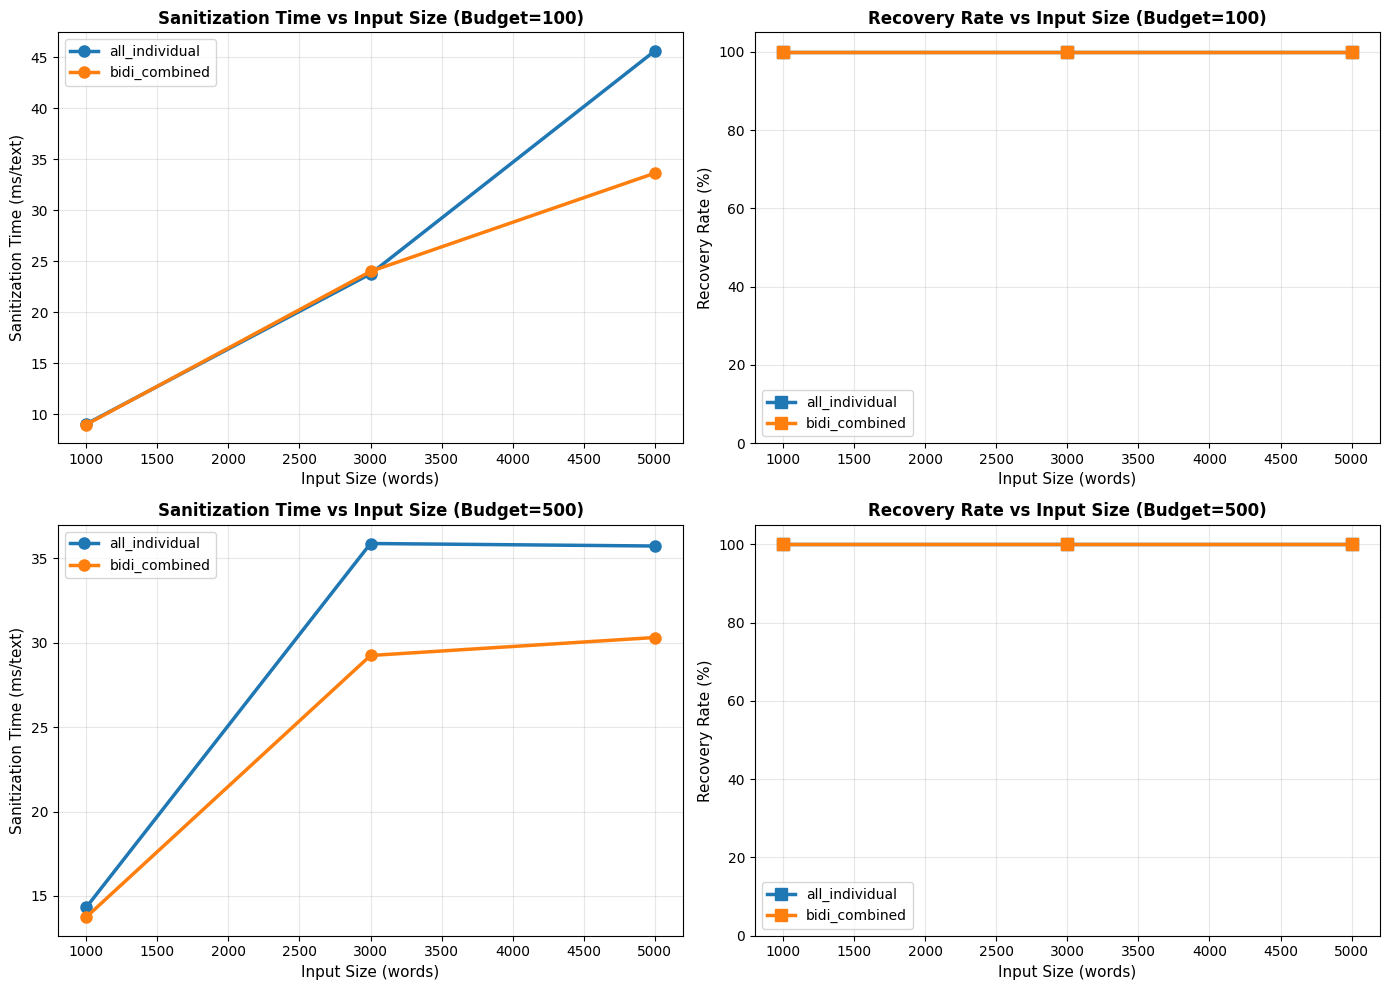


Results Summary:
 budget  input_size         config sanitize_ms recovered recovery_rate  sanitize_ms_num  recovery_rate_num
    100        1000 all_individual       9.055     50/50        100.0%            9.055              100.0
    100        1000  bidi_combined       8.995     50/50        100.0%            8.995              100.0
    100        3000 all_individual      23.772     50/50        100.0%           23.772              100.0
    100        3000  bidi_combined      24.009     50/50        100.0%           24.009              100.0
    100        5000 all_individual      45.623     50/50        100.0%           45.623              100.0
    100        5000  bidi_combined      33.641     50/50        100.0%           33.641              100.0
    500        1000 all_individual      14.325     50/50        100.0%           14.325              100.0
    500        1000  bidi_combined      13.746     50/50        100.0%           13.746              100.0
    500        3000

In [220]:
import matplotlib.pyplot as plt

# Display results
summary_df = pd.DataFrame(results)

# Convert numeric columns for plotting
summary_df['sanitize_ms_num'] = summary_df['sanitize_ms'].astype(float)
summary_df['recovery_rate_num'] = summary_df['recovery_rate'].str.rstrip('%').astype(float)

# Create separate subplots for each budget
fig, axes = plt.subplots(len(perturbation_budgets), 2, figsize=(14, 5*len(perturbation_budgets)))

# If only one budget, axes is 1D, make it 2D for consistency
if len(perturbation_budgets) == 1:
    axes = axes.reshape(1, -1)

# Plot for each budget
for idx, budget in enumerate(perturbation_budgets):
    budget_data = summary_df[summary_df['budget'] == budget]
    
    # Plot 1: Sanitization time vs input size (comparing configs)
    for config in budget_data['config'].unique():
        config_data = budget_data[budget_data['config'] == config]
        axes[idx, 0].plot(config_data['input_size'], config_data['sanitize_ms_num'], 
                    marker='o', linewidth=2.5, markersize=8, label=config)
    
    axes[idx, 0].set_xlabel('Input Size (words)', fontsize=11)
    axes[idx, 0].set_ylabel('Sanitization Time (ms/text)', fontsize=11)
    axes[idx, 0].set_title(f'Sanitization Time vs Input Size (Budget={budget})', fontsize=12, fontweight='bold')
    axes[idx, 0].legend(loc='best', fontsize=10)
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Plot 2: Recovery rate vs input size (comparing configs)
    for config in budget_data['config'].unique():
        config_data = budget_data[budget_data['config'] == config]
        axes[idx, 1].plot(config_data['input_size'], config_data['recovery_rate_num'], 
                    marker='s', linewidth=2.5, markersize=8, label=config)
    
    axes[idx, 1].set_xlabel('Input Size (words)', fontsize=11)
    axes[idx, 1].set_ylabel('Recovery Rate (%)', fontsize=11)
    axes[idx, 1].set_title(f'Recovery Rate vs Input Size (Budget={budget})', fontsize=12, fontweight='bold')
    axes[idx, 1].legend(loc='best', fontsize=10)
    axes[idx, 1].grid(True, alpha=0.3)
    axes[idx, 1].set_ylim([0, 105])

plt.tight_layout()
plt.show()
fig.savefig("input_size_budget_comparison.png", dpi=150, bbox_inches='tight')

print("\nResults Summary:")
print(summary_df.to_string(index=False))
print("\nVisualization saved as 'input_size_budget_comparison.png'")


In [11]:
budget = 1

# tag_attack = TagAttack(perturbation_budget=budget)
# vs_attack = VariationSelectorAttack(perturbation_budget=budget)
invisible_attack = InvisibleCharAttack(perturbation_budget=budget)
homoglyph_attack = HomoglyphAttack(perturbation_budget=budget)
deletion_attack = DeletionCharAttack(perturbation_budget=budget)
bidi_attack = BidiAttack(perturbation_budget=budget)
    
    
perturbed = tag_attack.perturb(text)
perturbed = vs_attack.perturb(perturbed)
perturbed = invisible_attack.perturb(perturbed)
perturbed = homoglyph_attack.perturb(perturbed)
perturbed = deletion_attack.perturb(perturbed)
perturbed = bidi_attack.perturb(perturbed)

print([hex(ord(c)) for c in perturbed])
print([hex(ord(c)) for c in text])

# 3. Tokenize and predict
encoded_input = tokenizer(perturbed, return_tensors='pt')
output = model(**encoded_input)

# 4. Interpret the result
scores = output.logits[0].detach().numpy()
# Get the predicted class index (e.g., 0, 1, or 2)
predicted_class_id = scores.argmax()

# The model's config contains the mapping from ID to label
labels = model.config.id2label
predicted_label = labels[predicted_class_id]

print(f"Text: {text}")
print(f"Predicted Sentiment: {predicted_label}")

['0x75', '0x6e', '0x6c', '0x69', '0x6b', '0x65', '0x20', '0x74', '0x68', '0x65', '0x20', '0x73', '0x70', '0x65', '0xe002d', '0x65', '0x64', '0x79', '0x4a', '0x8', '0x20', '0xe0001', '0x77', '0x68', '0x61', '0x6d', '0x2d', '0x62', '0x61', '0x6d', '0x20', '0x65', '0x66', '0x66', '0x65', '0x63', '0x74', '0x20', '0xe0052', '0x6f', '0x66', '0x20', '0x6d', '0x6f', '0x200d', '0x73', '0x74', '0x20', '0x68', '0xe01a2', '0x6f', '0x6c', '0x6c', '0x79', '0x77', '0x6f', '0x6f', '0x64', '0x20', '0x6f', '0x66', '0x66', '0x65', '0x72', '0x69', '0x6e', '0x67', '0x73', '0x20', '0x2c', '0x20', '0xe0173', '0x63', '0x68', '0x61', '0x72', '0xe012d', '0x61', '0x63', '0xe01ce', '0x74', '0x65', '0xe0055', '0x72', '0x20', '0x64', '0x65', '0x76', '0x65', '0x6c', '0x6f', '0x70', '0x6d', '0x65', '0xe0164', '0x6e', '0xe01be', '0x74', '0x20', '0x2d', '0x2d', '0x20', '0x61', '0x6e', '0x64', '0x20', '0x6d', '0x6f', '0x72', '0x65', '0x20', '0x69', '0x6d', '0x70', '0x6f', '0x72', '0xe0115', '0x74', '0x61', '0x6e', '0x74

# Sentiment Analysis Full Experiment

In [12]:

# Sentiment Classification Attack Experiment
# Test before/after perturbation + after sanitization for each attack type on SST-2

import pandas as pd
import numpy as np
from datasets import load_dataset

# Load SST-2 dataset
print("Loading SST-2 dataset...")
sst2 = load_dataset("glue", "sst2", split="validation")
num_samples = 100  # Use first 100 samples for experiment
texts = sst2['sentence'][:num_samples]

# Initialize lists to store results
results = []

# Perturbation budgets to test
budgets = list(range(0, 11))  # 0 to 5

print(f"Testing {num_samples} samples across budgets: {budgets}\n")

# Define attack types
attack_types = ['tag', 'variation_selector', 'invisible', 'homoglyph', 'deletion', 'bidi', 'combined']

# Attack to Sanitizer mapping
attack_sanitizer_map = {
    'tag': 'add_tag_sanitizer',
    'variation_selector': 'add_variation_selector_sanitizer',
    'invisible': 'add_invisible_sanitizer',
    'homoglyph': 'add_homoglyph_sanitizer',
    'deletion': 'add_deletion_sanitizer',
    'bidi': 'add_bidi_sanitizer',
    'combined': 'all'  # Special case: use all sanitizers
}

# Process each budget
for budget in budgets:
    print(f"\n=== Budget: {budget} ===")
    
    # Initialize attacks
    tag_attack = TagAttack(perturbation_budget=budget)
    vs_attack = VariationSelectorAttack(perturbation_budget=budget)
    invisible_attack = InvisibleCharAttack(perturbation_budget=budget)
    homoglyph_attack = HomoglyphAttack(perturbation_budget=budget)
    deletion_attack = DeletionCharAttack(perturbation_budget=budget)
    bidi_attack = BidiAttack(perturbation_budget=budget)
    
    # Get predictions for original texts (budget 0 for efficiency)
    if budget == 0:
        print("Getting baseline predictions for original texts...")
        original_preds = []
        original_probs = []
        
        for i, text in enumerate(texts):
            encoded = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
            with torch.no_grad():
                output = model(**encoded)
            scores = output.logits[0].detach().numpy()
            pred_id = scores.argmax()
            pred_prob = scores.max()
            original_preds.append(model.config.id2label[pred_id])
            original_probs.append(pred_prob)
            
            if (i + 1) % 20 == 0:
                print(f"  Processed {i + 1}/{num_samples} samples")
    
    # Test each attack type
    for attack_name in attack_types:
        print(f"  Testing {attack_name} attack...", end=" ", flush=True)
        
        perturbed_preds = []
        perturbed_probs = []
        sanitized_preds = []
        sanitized_probs = []
        
        for text in texts:
            # Apply attack
            if attack_name == 'tag':
                perturbed = tag_attack.perturb(text)
            elif attack_name == 'variation_selector':
                perturbed = vs_attack.perturb(text)
            elif attack_name == 'invisible':
                perturbed = invisible_attack.perturb(text)
            elif attack_name == 'homoglyph':
                perturbed = homoglyph_attack.perturb(text)
            elif attack_name == 'deletion':
                perturbed = deletion_attack.perturb(text)
            elif attack_name == 'bidi':
                perturbed = bidi_attack.perturb(text)
            elif attack_name == 'combined':
                perturbed = tag_attack.perturb(text)
                perturbed = vs_attack.perturb(perturbed)
                perturbed = invisible_attack.perturb(perturbed)
                perturbed = homoglyph_attack.perturb(perturbed)
                perturbed = deletion_attack.perturb(perturbed)
                perturbed = bidi_attack.perturb(perturbed)
            
            # Get prediction on perturbed text
            encoded = tokenizer(perturbed, return_tensors='pt', max_length=512, truncation=True)
            with torch.no_grad():
                output = model(**encoded)
            scores = output.logits[0].detach().numpy()
            pred_id = scores.argmax()
            pred_prob = scores.max()
            perturbed_preds.append(model.config.id2label[pred_id])
            perturbed_probs.append(pred_prob)
            
            # Apply sanitizers to the perturbed text
            p = _pipeline.Pipeline()
            if attack_sanitizer_map[attack_name] == 'all':
                p.add_bidi_sanitizer()
                p.add_tag_sanitizer()
                p.add_variation_selector_sanitizer()
                p.add_invisible_sanitizer()
                p.add_homoglyph_sanitizer()
                p.add_deletion_sanitizer()
            else:
                getattr(p, attack_sanitizer_map[attack_name])()
            
            sanitized = p.sanitize(perturbed)
            
            # Get prediction on sanitized text
            encoded = tokenizer(sanitized, return_tensors='pt', max_length=512, truncation=True)
            with torch.no_grad():
                output = model(**encoded)
            scores = output.logits[0].detach().numpy()
            pred_id = scores.argmax()
            pred_prob = scores.max()
            sanitized_preds.append(model.config.id2label[pred_id])
            sanitized_probs.append(pred_prob)
        
        # Calculate metrics
        attack_success_rate = sum(1 for i in range(num_samples) if perturbed_preds[i] != original_preds[i]) / num_samples * 100
        defense_recovery_rate = sum(1 for i in range(num_samples) if sanitized_preds[i] == original_preds[i]) / num_samples * 100
        avg_perturb_prob_drop = np.mean([original_probs[i] - perturbed_probs[i] for i in range(num_samples)])
        
        results.append({
            'budget': budget,
            'attack': attack_name,
            'attack_success_rate': f"{attack_success_rate:.1f}%",
            'defense_recovery_rate': f"{defense_recovery_rate:.1f}%",
            'avg_perturb_prob_drop': f"{avg_perturb_prob_drop:.4f}"        })
        
        print(f"Attack Success: {attack_success_rate:.1f}% | Defense Recovery: {defense_recovery_rate:.1f}%")

# Create results dataframe
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("EXPERIMENT RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))

# Save to CSV
csv_file = "sentiment_attack_defense_results.csv"
results_df.to_csv(csv_file, index=False)
print(f"\nResults saved to {csv_file}")


Loading SST-2 dataset...
Testing 100 samples across budgets: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


=== Budget: 0 ===
Getting baseline predictions for original texts...
  Processed 20/100 samples
  Processed 40/100 samples
  Processed 60/100 samples
  Processed 80/100 samples
  Processed 100/100 samples
  Testing tag attack... 

KeyboardInterrupt: 

In [ ]:
results_df.head()

,budget,attack,attack_success_rate,defense_recovery_rate,avg_perturb_prob_drop,attack_success_rate_num,defense_recovery_rate_num,avg_perturb_prob_drop_num
0,0,tag,0.0%,100.0%,0.0000,0.0,100.0,0.0
1,0,variation_selector,0.0%,100.0%,0.0000,0.0,100.0,0.0
2,0,invisible,0.0%,100.0%,0.0000,0.0,100.0,0.0
3,0,homoglyph,0.0%,100.0%,0.0000,0.0,100.0,0.0
4,0,deletion,0.0%,100.0%,0.0000,0.0,100.0,0.0


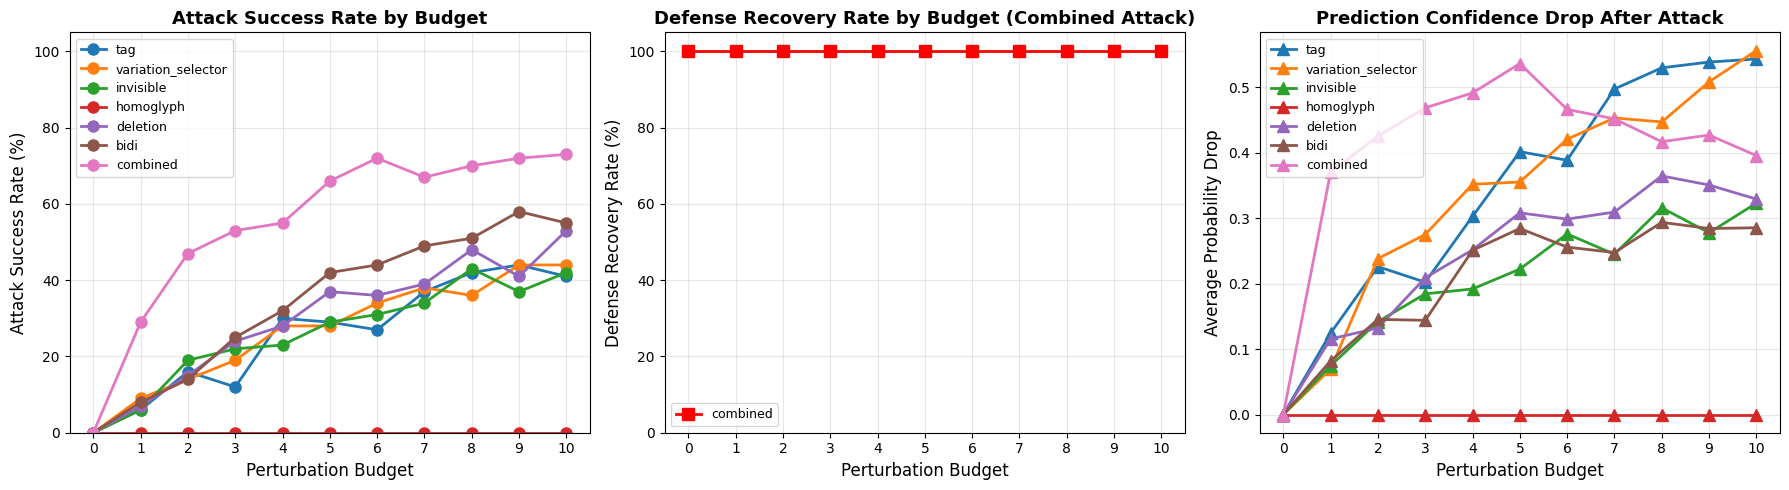


Visualization complete!


In [ ]:

# Visualization: Attack Success vs Defense Recovery by Budget and Attack Type

import matplotlib.pyplot as plt

# Parse the results dataframe for plotting
results_df['attack_success_rate_num'] = results_df['attack_success_rate'].str.rstrip('%').astype(float)
results_df['defense_recovery_rate_num'] = results_df['defense_recovery_rate'].str.rstrip('%').astype(float)
results_df['avg_perturb_prob_drop_num'] = results_df['avg_perturb_prob_drop_num'].astype(float)

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Attack Success Rate vs Budget
for attack in attack_types:
    attack_data = results_df[results_df['attack'] == attack]
    axes[0].plot(attack_data['budget'], attack_data['attack_success_rate_num'], 
                marker='o', label=attack, linewidth=2, markersize=8)

axes[0].set_xlabel('Perturbation Budget', fontsize=12)
axes[0].set_ylabel('Attack Success Rate (%)', fontsize=12)
axes[0].set_title('Attack Success Rate by Budget', fontsize=13, fontweight='bold')
axes[0].legend(loc='best', fontsize=9)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(budgets)
axes[0].set_ylim([0, 105])

# Plot 2: Defense Recovery Rate vs Budget (Combined only)
combined_data = results_df[results_df['attack'] == 'combined']
axes[1].plot(combined_data['budget'], combined_data['defense_recovery_rate_num'], 
            marker='s', label='combined', linewidth=2, markersize=8, color='red')

axes[1].set_xlabel('Perturbation Budget', fontsize=12)
axes[1].set_ylabel('Defense Recovery Rate (%)', fontsize=12)
axes[1].set_title('Defense Recovery Rate by Budget (Combined Attack)', fontsize=13, fontweight='bold')
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(budgets)
axes[1].set_ylim([0, 105])

# Plot 3: Prediction Probability Drop vs Budget
for attack in attack_types:
    attack_data = results_df[results_df['attack'] == attack]
    axes[2].plot(attack_data['budget'], attack_data['avg_perturb_prob_drop_num'], 
                marker='^', label=attack, linewidth=2, markersize=8)

axes[2].set_xlabel('Perturbation Budget', fontsize=12)
axes[2].set_ylabel('Average Probability Drop', fontsize=12)
axes[2].set_title('Prediction Confidence Drop After Attack', fontsize=13, fontweight='bold')
axes[2].legend(loc='best', fontsize=9)
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(budgets)

plt.tight_layout()
plt.show()
fig.savefig("attack_defense_visualization.png")
print("\nVisualization complete!")


In [ ]:

# Detailed Analysis: Compare attack vs defense at each budget level

print("\n" + "="*80)
print("DETAILED ATTACK vs DEFENSE ANALYSIS BY BUDGET")
print("="*80)

for budget in budgets:
    print(f"\n--- Budget {budget} ---")
    budget_results = results_df[results_df['budget'] == budget].sort_values('attack_success_rate_num', ascending=False)
    
    print(f"\nRanking by Attack Success Rate (Before Defense):")
    for idx, row in budget_results.iterrows():
        print(f"  {row['attack']:20} | Attack: {row['attack_success_rate']:>6} | Recovery: {row['defense_recovery_rate']:>6} | Prob: {row['avg_perturb_prob_drop']:>8}")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

print("\nAttack Effectiveness (Average across all budgets):")
attack_summary = results_df.groupby('attack').agg({
    'attack_success_rate_num': 'mean',
    'defense_recovery_rate_num': 'mean',
    'avg_perturb_prob_drop_num': 'mean',
    'avg_sanitize_prob_recovery_num': 'mean'
}).round(2)
attack_summary.columns = ['Avg Attack Success (%)', 'Avg Defense Recovery (%)', 'Avg Prob Drop', 'Avg Prob Recovery']
attack_summary = attack_summary.sort_values('Avg Attack Success (%)', ascending=False)
print(attack_summary)

print("\nBudget Effectiveness (Average across all attacks):")
budget_summary = results_df.groupby('budget').agg({
    'attack_success_rate_num': 'mean',
    'defense_recovery_rate_num': 'mean',
    'avg_perturb_prob_drop_num': 'mean',
    'avg_sanitize_prob_recovery_num': 'mean'
}).round(2)
budget_summary.columns = ['Avg Attack Success (%)', 'Avg Defense Recovery (%)', 'Avg Prob Drop', 'Avg Prob Recovery']
print(budget_summary)

# Defense Effectiveness per Attack
print("\nDefense Effectiveness by Attack Type (Recovery Rate Gain from Sanitization):")
defense_effectiveness = results_df.copy()
defense_effectiveness['recovery_improvement'] = defense_effectiveness['defense_recovery_rate_num'] - (100 - defense_effectiveness['attack_success_rate_num'])
defense_effectiveness = defense_effectiveness.groupby('attack')['recovery_improvement'].mean().round(2).sort_values(ascending=False)
print(defense_effectiveness)



DETAILED ATTACK vs DEFENSE ANALYSIS BY BUDGET

--- Budget 0 ---

Ranking by Attack Success Rate (Before Defense):
  tag                  | Attack:   0.0% | Recovery: 100.0% | Prob:   0.0000
  variation_selector   | Attack:   0.0% | Recovery: 100.0% | Prob:   0.0000
  invisible            | Attack:   0.0% | Recovery: 100.0% | Prob:   0.0000
  homoglyph            | Attack:   0.0% | Recovery: 100.0% | Prob:   0.0000
  deletion             | Attack:   0.0% | Recovery: 100.0% | Prob:   0.0000
  bidi                 | Attack:   0.0% | Recovery: 100.0% | Prob:   0.0000
  combined             | Attack:   0.0% | Recovery: 100.0% | Prob:   0.0000

--- Budget 1 ---

Ranking by Attack Success Rate (Before Defense):
  combined             | Attack:  18.0% | Recovery: 100.0% | Prob:   0.2839
  bidi                 | Attack:  15.0% | Recovery:  86.0% | Prob:   0.1162
  tag                  | Attack:  14.0% | Recovery: 100.0% | Prob:   0.0844
  deletion             | Attack:  13.0% | Recovery: 100.0

# Performance Comparison: Individual vs Combined Sanitizer

In [ ]:
import time

# Performance Comparison: Bidi Sanitizer vs Combined Sanitizer
print("\n" + "="*80)
print("PERFORMANCE COMPARISON: BIDI vs COMBINED SANITIZER")
print("="*80)

# Use the same perturbed texts from the experiment (combined attack with budget=3)
print("\nGenerating combined attack texts for performance comparison...")
test_texts = texts[:50]  # Use 50 samples for performance testing
budget_for_perf_test = 3

tag_attack = TagAttack(perturbation_budget=budget_for_perf_test)
vs_attack = VariationSelectorAttack(perturbation_budget=budget_for_perf_test)
invisible_attack = InvisibleCharAttack(perturbation_budget=budget_for_perf_test)
homoglyph_attack = HomoglyphAttack(perturbation_budget=budget_for_perf_test)
deletion_attack = DeletionCharAttack(perturbation_budget=budget_for_perf_test)
bidi_attack = BidiAttack(perturbation_budget=budget_for_perf_test)

# Generate perturbed texts
perturbed_test_texts = []
for text in test_texts:
    perturbed = tag_attack.perturb(text)
    perturbed = vs_attack.perturb(perturbed)
    perturbed = invisible_attack.perturb(perturbed)
    perturbed = homoglyph_attack.perturb(perturbed)
    perturbed = deletion_attack.perturb(perturbed)
    perturbed = bidi_attack.perturb(perturbed)
    perturbed_test_texts.append(perturbed)

print(f"Generated {len(perturbed_test_texts)} perturbed texts with combined attack (budget={budget_for_perf_test})")

# Test 1: Bidi sanitizer only
print("\n--- Testing Bidi Sanitizer ---")
start_time = time.time()
for text in perturbed_test_texts:
    p = _pipeline.Pipeline()
    p.add_bidi_sanitizer()
    _ = p.sanitize(text)

bidi_time = (time.time() - start_time) / len(perturbed_test_texts) * 1000  # ms per text
print(f"Bidi sanitizer: {bidi_time:.3f} ms/text")

# Test 2: Combined sanitizer
print("\n--- Testing Combined Sanitizer ---")
start_time = time.time()
for text in perturbed_test_texts:
    p = _pipeline.Pipeline()
    p.add_combined_sanitizer()
    _ = p.sanitize(text)

combined_time = (time.time() - start_time) / len(perturbed_test_texts) * 1000  # ms per text
print(f"Combined sanitizer: {combined_time:.3f} ms/text")

# Calculate performance metrics
speedup = bidi_time / combined_time

print("\n--- Performance Comparison Summary ---")
print(f"Bidi Sanitizer:       {bidi_time:.3f} ms/text")
print(f"Combined Sanitizer:   {combined_time:.3f} ms/text")
print(f"Speedup (Bidi/Combined): {speedup:.2f}x")

# Create comparison dataframe
perf_comparison = pd.DataFrame({
    'Sanitizer': [
        'Bidi Only',
        'Combined'
    ],
    'Time per Text (ms)': [
        f"{bidi_time:.3f}",
        f"{combined_time:.3f}"
    ],
    'Relative Speed': [
        f"{speedup:.2f}x",
        "1.00x"
    ]
})

print("\n" + perf_comparison.to_string(index=False))

# Performance Visualization

In [ ]:
# Visualize performance comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Extract numeric values from dataframe
configs = perf_comparison['Sanitizer Configuration'].tolist()
times = [float(t) for t in perf_comparison['Time per Text (ms)'].tolist()]
speedups = [float(s.replace('x', '')) for s in perf_comparison['Speedup vs Combined'].tolist()]

# Plot 1: Execution Time Comparison
colors = ['#ff6b6b', '#ff6b6b', '#51cf66']
axes[0].bar(configs, times, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Time per Text (ms)', fontsize=12, fontweight='bold')
axes[0].set_title('Sanitization Time Comparison', fontsize=13, fontweight='bold')
axes[0].set_ylim([0, max(times) * 1.2])
for i, (config, time_val) in enumerate(zip(configs, times)):
    axes[0].text(i, time_val + max(times)*0.05, f'{time_val:.3f}', 
                ha='center', fontsize=11, fontweight='bold')
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Speedup Comparison
speedup_labels = [f'{s:.2f}x' for s in speedups]
axes[1].bar(configs, speedups, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Speedup Factor', fontsize=12, fontweight='bold')
axes[1].set_title('Speedup vs Combined Sanitizer', fontsize=13, fontweight='bold')
axes[1].axhline(y=1.0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_ylim([0, max(speedups) * 1.2])
for i, (config, speedup) in enumerate(zip(configs, speedups)):
    axes[1].text(i, speedup + max(speedups)*0.05, f'{speedup:.2f}x', 
                ha='center', fontsize=11, fontweight='bold')
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
fig.savefig("performance_comparison.png", dpi=150)
print("Performance comparison visualization saved as 'performance_comparison.png'")